# Resolution Refinement for Enlarged Scale Images Using GANs

In [1]:
#starting to build GANs network
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
images=np.load('data.npy')
resized8=np.load('array8.npy')
%matplotlib inline

In [2]:
print("Training set size:\t",len(images))

Training set size:	 50000


In [3]:
images=images[:200]
resized8=resized8[:200]
print(len(images))

200


In [4]:
import tensorflow.contrib.layers as lays
def generator(input,reuse=None):
    with tf.variable_scope('gen',reuse=reuse):
        net = lays.conv2d_transpose(input,16, [5, 5], stride=2, padding='SAME')
        net = lays.conv2d_transpose(net,32, [5, 5], stride=2, padding='SAME')
        net = lays.conv2d_transpose(net, 3, [5, 5], stride=1, padding='SAME', activation_fn=tf.nn.tanh)
        return net

In [5]:
def discriminator(input,reuse=True):
    with tf.variable_scope('dis',reuse=reuse):
        net = lays.conv2d(input, 32, [5, 5], stride=2, padding='SAME',activation_fn=tf.nn.relu) #16 x16 x 32
        net = lays.conv2d(net, 16, [5, 5], stride=2, padding='SAME',activation_fn=tf.nn.relu) # 8 x 8 x 16
        net = lays.conv2d(net, 8, [5, 5], stride=4, padding='SAME',activation_fn=tf.nn.relu) #--> 2 x 2 x 8
        dim = int(np.prod(net.get_shape()[1:]))
        fc1 = tf.reshape(net, shape=[-1, dim], name='fc1')
        w2 = tf.get_variable('w2', shape=[fc1.shape[-1], 1], dtype=tf.float32,initializer=tf.truncated_normal_initializer(stddev=0.02))
        b2 = tf.get_variable('b2', shape=[1], dtype=tf.float32,initializer=tf.constant_initializer(0.0))
        logits = tf.add(tf.matmul(fc1, w2), b2, name='logits')
        Dis_out = tf.nn.sigmoid(logits)
        return logits

In [6]:
tf.reset_default_graph()
real_images=tf.placeholder(tf.float32, (None,32, 32, 3))
inputs_= tf.placeholder(tf.float32, (None,8, 8, 3))
G=generator(inputs_)
D_real=discriminator(real_images,reuse=None)
D_fake=discriminator(G,reuse=True)

Instructions for updating:
Colocations handled automatically by placer.


In [7]:

def loss_func(logits_in,labels_in):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_in,labels=labels_in))
D_real_loss=loss_func(D_real,tf.ones_like(D_real)) #Smoothing for generalization
D_fake_loss=loss_func(D_fake,tf.zeros_like(D_fake))
D_loss=D_real_loss#+D_fake_loss
G_loss=loss_func(D_fake,tf.ones_like(D_fake))
#D_loss=tf.reduce_mean(D_fake)-tf.reduce_mean(D_real)
#G_loss=-tf.reduce_mean(D_fake)
S_loss = tf.reduce_mean((G-real_images)**2)


In [8]:
'''
D_loss =-tf.reduce_mean(tf.log(D_real) + tf.log(1- D_fake))
G_loss =-tf.reduce_mean(tf.log(D_fake))
S_loss = tf.reduce_mean((G-real_images)**2)
'''

'\nD_loss =-tf.reduce_mean(tf.log(D_real) + tf.log(1- D_fake))\nG_loss =-tf.reduce_mean(tf.log(D_fake))\nS_loss = tf.reduce_mean((G-real_images)**2)\n'

==>>*Due to PC restriction for Training large number of the data,and it takes many times for training, here I run the training iteration only for 200 sample images, and 100 epochs*

In [9]:
lr=0.0002 #0.0002
gama=0.2
#Do this when multiple networks interact with each other
tvars=tf.trainable_variables()  #returns all variables created(the two variable scopes) and makes trainable true
d_vars=[var for var in tvars if 'dis' in var.name]
g_vars=[var for var in tvars if 'gen' in var.name]
GENLOSS=(1-gama)*G_loss+gama*S_loss# reducing sloss 0.2,0.1,...more close to gans
D_trainer=tf.train.AdamOptimizer(lr).minimize(D_loss,var_list=d_vars)
G_trainer=tf.train.AdamOptimizer(lr).minimize(GENLOSS,var_list=g_vars) #0.001*g_loss+d_loss
#G_trainer=tf.train.AdamOptimizer(lr).minimize((0.001*G_loss+D_loss),var_list=g_vars)
batch_size=20
epochs=100
h=len(images)
init=tf.global_variables_initializer()

In [10]:
samples=[] #generator examples
ADVloss=[]
MSEloss=[]
Daverageloss=[]
Gaverageloss=[]
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(epochs):
        num_batches=h//batch_size
        print('epoch ',epoch)
        DLOSS=[]
        GLOSS=[]
        G_LOSS=[]
        S_LOSS=[]
        for i in range(num_batches):
            #m=i*batch_size
            batch_images=images[i*batch_size : (i+1)*batch_size].reshape(batch_size,32,32,3)
            batch_z=resized8[i*batch_size : (i+1)*batch_size].reshape(batch_size,8,8,3)
            Go=sess.run(generator(inputs_,reuse=True),feed_dict={inputs_:batch_z})
           # _=sess.run(D_trainer,feed_dict={real_images:batch_images,inputs_:batch_z})
           # _=sess.run(G_trainer,feed_dict={inputs_:batch_z})
            Dloss, _ = sess.run([D_loss, D_trainer], feed_dict={real_images:batch_images,G:Go})
            for dd in range(5): 
                Genloss,ADV,MSE, _ = sess.run([GENLOSS,G_loss,S_loss,G_trainer], feed_dict={inputs_:batch_z,real_images:batch_images})
            #Genloss, _ = sess.run([G_loss, G_trainer], feed_dict={inputs_:batch_z,real_images:batch_images})
            G_LOSS.append(ADV)
            S_LOSS.append(MSE)
            DLOSS.append(Dloss)
            GLOSS.append(Genloss)
            if epoch==epochs-1:
                samples.append(Go)
            #Genloss, _ = sess.run([g_loss, train_Gen], feed_dict={Sr:G,Hr:batch_images})
            print('epoch {} batch number {}   discrim batch loss: {} Gen batch loss: {}'.format(epoch,i,Dloss,Genloss))
        MeanDloss=np.mean(DLOSS)
        MeanGlos=np.mean(GLOSS)
        meanADVloss=np.mean(G_LOSS)
        meanMSEloss=np.mean(S_LOSS)
        Daverageloss.append(np.mean(DLOSS))
        Gaverageloss.append(MeanGlos)
        ADVloss.append(meanADVloss)
        MSEloss.append(meanMSEloss)
        print(' Average discrim loss: {} Average Gen loss: {} Average MSE Loss: {}'.format(MeanDloss,MeanGlos,meanMSEloss))
       
     

epoch  0
epoch 0 batch number 0   discrim batch loss: 0.6933282613754272 Gen batch loss: 0.6025473475456238
epoch 0 batch number 1   discrim batch loss: 0.6928510069847107 Gen batch loss: 0.5993842482566833
epoch 0 batch number 2   discrim batch loss: 0.6923726797103882 Gen batch loss: 0.5999669432640076
epoch 0 batch number 3   discrim batch loss: 0.6915833950042725 Gen batch loss: 0.5907125473022461
epoch 0 batch number 4   discrim batch loss: 0.6907221674919128 Gen batch loss: 0.5795264840126038
epoch 0 batch number 5   discrim batch loss: 0.6891930103302002 Gen batch loss: 0.5814400911331177
epoch 0 batch number 6   discrim batch loss: 0.6871713399887085 Gen batch loss: 0.5692955255508423
epoch 0 batch number 7   discrim batch loss: 0.6863369345664978 Gen batch loss: 0.5578272938728333
epoch 0 batch number 8   discrim batch loss: 0.6850796937942505 Gen batch loss: 0.5544566512107849
epoch 0 batch number 9   discrim batch loss: 0.6813166737556458 Gen batch loss: 0.549112856388092
 A

epoch 7 batch number 3   discrim batch loss: 0.0017725781071931124 Gen batch loss: 0.006556748878210783
epoch 7 batch number 4   discrim batch loss: 0.0025316893588751554 Gen batch loss: 0.006127266213297844
epoch 7 batch number 5   discrim batch loss: 0.000683268706779927 Gen batch loss: 0.006812586914747953
epoch 7 batch number 6   discrim batch loss: 0.0030826644506305456 Gen batch loss: 0.006094433832913637
epoch 7 batch number 7   discrim batch loss: 0.0009008271736092865 Gen batch loss: 0.00512660713866353
epoch 7 batch number 8   discrim batch loss: 0.0032595552038401365 Gen batch loss: 0.006101316772401333
epoch 7 batch number 9   discrim batch loss: 0.001560293254442513 Gen batch loss: 0.005038515664637089
 Average discrim loss: 0.002387069398537278 Average Gen loss: 0.0063444385305047035 Average MSE Loss: 0.028789862990379333
epoch  8
epoch 8 batch number 0   discrim batch loss: 0.001884786761365831 Gen batch loss: 0.006158797070384026
epoch 8 batch number 1   discrim batch l

epoch 14 batch number 3   discrim batch loss: 0.0001402934140060097 Gen batch loss: 0.003602084005251527
epoch 14 batch number 4   discrim batch loss: 0.00027928093913942575 Gen batch loss: 0.00334746390581131
epoch 14 batch number 5   discrim batch loss: 4.3125088268425316e-05 Gen batch loss: 0.0035044371616095304
epoch 14 batch number 6   discrim batch loss: 0.0007724367897026241 Gen batch loss: 0.003295104717835784
epoch 14 batch number 7   discrim batch loss: 9.023736492963508e-05 Gen batch loss: 0.002606313908472657
epoch 14 batch number 8   discrim batch loss: 0.0006765156867913902 Gen batch loss: 0.0034479147288948298
epoch 14 batch number 9   discrim batch loss: 0.00029608901240862906 Gen batch loss: 0.00274811964482069
 Average discrim loss: 0.00031418725848197937 Average Gen loss: 0.0033266586251556873 Average MSE Loss: 0.015670692548155785
epoch  15
epoch 15 batch number 0   discrim batch loss: 0.0003541344194673002 Gen batch loss: 0.0035663556773215532
epoch 15 batch number

epoch 21 batch number 2   discrim batch loss: 5.974571831757203e-05 Gen batch loss: 0.002831012010574341
epoch 21 batch number 3   discrim batch loss: 4.7635450755478814e-05 Gen batch loss: 0.003118644468486309
epoch 21 batch number 4   discrim batch loss: 0.00010741032747318968 Gen batch loss: 0.0027724902611225843
epoch 21 batch number 5   discrim batch loss: 1.2244131539773662e-05 Gen batch loss: 0.002976622199639678
epoch 21 batch number 6   discrim batch loss: 0.0004196085501462221 Gen batch loss: 0.0027580647729337215
epoch 21 batch number 7   discrim batch loss: 3.0424062060774304e-05 Gen batch loss: 0.0022012770641595125
epoch 21 batch number 8   discrim batch loss: 0.00032044496037997305 Gen batch loss: 0.0029229563660919666
epoch 21 batch number 9   discrim batch loss: 0.00013012993440497667 Gen batch loss: 0.0022913517896085978
 Average discrim loss: 0.0001391857222188264 Average Gen loss: 0.002775487257167697 Average MSE Loss: 0.013370481319725513
epoch  22
epoch 22 batch n

epoch 28 batch number 1   discrim batch loss: 4.33944005635567e-05 Gen batch loss: 0.002513296902179718
epoch 28 batch number 2   discrim batch loss: 2.6094337954418734e-05 Gen batch loss: 0.0026012836024165154
epoch 28 batch number 3   discrim batch loss: 2.056006997008808e-05 Gen batch loss: 0.002887124428525567
epoch 28 batch number 4   discrim batch loss: 5.158660496817902e-05 Gen batch loss: 0.00248944154009223
epoch 28 batch number 5   discrim batch loss: 4.625767815014115e-06 Gen batch loss: 0.002742981305345893
epoch 28 batch number 6   discrim batch loss: 0.0002646532957442105 Gen batch loss: 0.0024850270710885525
epoch 28 batch number 7   discrim batch loss: 1.3189998753659893e-05 Gen batch loss: 0.0020180651918053627
epoch 28 batch number 8   discrim batch loss: 0.00018113285477738827 Gen batch loss: 0.002620330546051264
epoch 28 batch number 9   discrim batch loss: 6.928051880095154e-05 Gen batch loss: 0.0020638713613152504
 Average discrim loss: 7.616079528816044e-05 Avera

epoch 35 batch number 0   discrim batch loss: 4.767397331306711e-05 Gen batch loss: 0.0024999675806611776
epoch 35 batch number 1   discrim batch loss: 2.12444610951934e-05 Gen batch loss: 0.0022333452943712473
epoch 35 batch number 2   discrim batch loss: 1.210178652399918e-05 Gen batch loss: 0.00239867577329278
epoch 35 batch number 3   discrim batch loss: 9.509240044280887e-06 Gen batch loss: 0.002709833439439535
epoch 35 batch number 4   discrim batch loss: 2.6474375772522762e-05 Gen batch loss: 0.0022311315406113863
epoch 35 batch number 5   discrim batch loss: 1.8735194089458673e-06 Gen batch loss: 0.0025290041230618954
epoch 35 batch number 6   discrim batch loss: 0.00017615400429349393 Gen batch loss: 0.0022715439554303885
epoch 35 batch number 7   discrim batch loss: 6.000242137815803e-06 Gen batch loss: 0.0018557916628196836
epoch 35 batch number 8   discrim batch loss: 0.00010808328079292551 Gen batch loss: 0.0024010958150029182
epoch 35 batch number 9   discrim batch loss: 

epoch 42 batch number 0   discrim batch loss: 2.3156799215939827e-05 Gen batch loss: 0.002315156627446413
epoch 42 batch number 1   discrim batch loss: 9.182006579067092e-06 Gen batch loss: 0.0020514712668955326
epoch 42 batch number 2   discrim batch loss: 4.884233021584805e-06 Gen batch loss: 0.0022576209157705307
epoch 42 batch number 3   discrim batch loss: 3.856120656564599e-06 Gen batch loss: 0.0025831919629126787
epoch 42 batch number 4   discrim batch loss: 1.2152581803093199e-05 Gen batch loss: 0.002064034342765808
epoch 42 batch number 5   discrim batch loss: 6.535237275784311e-07 Gen batch loss: 0.002375302603468299
epoch 42 batch number 6   discrim batch loss: 0.00010982248932123184 Gen batch loss: 0.0020996995735913515
epoch 42 batch number 7   discrim batch loss: 2.36234518524725e-06 Gen batch loss: 0.0017511933110654354
epoch 42 batch number 8   discrim batch loss: 6.011411460349336e-05 Gen batch loss: 0.002238165121525526
epoch 42 batch number 9   discrim batch loss: 1.

epoch 49 batch number 0   discrim batch loss: 1.091275225917343e-05 Gen batch loss: 0.002203092910349369
epoch 49 batch number 1   discrim batch loss: 3.849404492939357e-06 Gen batch loss: 0.0019450507825240493
epoch 49 batch number 2   discrim batch loss: 1.909238562802784e-06 Gen batch loss: 0.0021602814085781574
epoch 49 batch number 3   discrim batch loss: 1.5197526863630628e-06 Gen batch loss: 0.002506828401237726
epoch 49 batch number 4   discrim batch loss: 5.484374469233444e-06 Gen batch loss: 0.0019743749871850014
epoch 49 batch number 5   discrim batch loss: 2.237355545275932e-07 Gen batch loss: 0.002264373004436493
epoch 49 batch number 6   discrim batch loss: 6.756321818102151e-05 Gen batch loss: 0.0019769473001360893
epoch 49 batch number 7   discrim batch loss: 9.116938599618152e-07 Gen batch loss: 0.0016837632283568382
epoch 49 batch number 8   discrim batch loss: 3.333407948957756e-05 Gen batch loss: 0.002135366899892688
epoch 49 batch number 9   discrim batch loss: 9.6

epoch 56 batch number 0   discrim batch loss: 5.604472335107857e-06 Gen batch loss: 0.002117929747328162
epoch 56 batch number 1   discrim batch loss: 1.7846462014858844e-06 Gen batch loss: 0.0018616915913298726
epoch 56 batch number 2   discrim batch loss: 8.315420245708083e-07 Gen batch loss: 0.002075314987450838
epoch 56 batch number 3   discrim batch loss: 6.675321628790698e-07 Gen batch loss: 0.002438341500237584
epoch 56 batch number 4   discrim batch loss: 2.726209231695975e-06 Gen batch loss: 0.0018970087403431535
epoch 56 batch number 5   discrim batch loss: 8.751273128382309e-08 Gen batch loss: 0.0021747963037341833
epoch 56 batch number 6   discrim batch loss: 4.385875217849389e-05 Gen batch loss: 0.0018839853582903743
epoch 56 batch number 7   discrim batch loss: 3.944840614167333e-07 Gen batch loss: 0.0016255701193585992
epoch 56 batch number 8   discrim batch loss: 1.991767749132123e-05 Gen batch loss: 0.002055168617516756
epoch 56 batch number 9   discrim batch loss: 5.2

epoch 63 batch number 0   discrim batch loss: 3.1970544114301447e-06 Gen batch loss: 0.0020555516239255667
epoch 63 batch number 1   discrim batch loss: 9.338468771602493e-07 Gen batch loss: 0.001797097153030336
epoch 63 batch number 2   discrim batch loss: 4.123090491248149e-07 Gen batch loss: 0.0020099622197449207
epoch 63 batch number 3   discrim batch loss: 3.3339873084514693e-07 Gen batch loss: 0.002389714354649186
epoch 63 batch number 4   discrim batch loss: 1.5142796883083065e-06 Gen batch loss: 0.0018372703343629837
epoch 63 batch number 5   discrim batch loss: 3.9798884188257944e-08 Gen batch loss: 0.0021064213942736387
epoch 63 batch number 6   discrim batch loss: 3.035940790141467e-05 Gen batch loss: 0.0018124519847333431
epoch 63 batch number 7   discrim batch loss: 1.9451252342150838e-07 Gen batch loss: 0.0015858298866078258
epoch 63 batch number 8   discrim batch loss: 1.291460921493126e-05 Gen batch loss: 0.0019948799163103104
epoch 63 batch number 9   discrim batch los

epoch 70 batch number 0   discrim batch loss: 1.9887854705302743e-06 Gen batch loss: 0.00200691563077271
epoch 70 batch number 1   discrim batch loss: 5.398376856646792e-07 Gen batch loss: 0.0017435508780181408
epoch 70 batch number 2   discrim batch loss: 2.2749630090856954e-07 Gen batch loss: 0.001955944811925292
epoch 70 batch number 3   discrim batch loss: 1.8506877097479446e-07 Gen batch loss: 0.0023534423671662807
epoch 70 batch number 4   discrim batch loss: 9.207361699736794e-07 Gen batch loss: 0.001790242618881166
epoch 70 batch number 5   discrim batch loss: 2.0453143179111066e-08 Gen batch loss: 0.002047913847491145
epoch 70 batch number 6   discrim batch loss: 2.216910434071906e-05 Gen batch loss: 0.0017570332856848836
epoch 70 batch number 7   discrim batch loss: 1.0671116967841954e-07 Gen batch loss: 0.0015542770270258188
epoch 70 batch number 8   discrim batch loss: 8.944438377511688e-06 Gen batch loss: 0.0019484343938529491
epoch 70 batch number 9   discrim batch loss: 

epoch 77 batch number 0   discrim batch loss: 1.3221431345300516e-06 Gen batch loss: 0.001968326512724161
epoch 77 batch number 1   discrim batch loss: 3.368549528204312e-07 Gen batch loss: 0.0016983954701572657
epoch 77 batch number 2   discrim batch loss: 1.3627271755467518e-07 Gen batch loss: 0.0019128336571156979
epoch 77 batch number 3   discrim batch loss: 1.1141927558355746e-07 Gen batch loss: 0.0023250915110111237
epoch 77 batch number 4   discrim batch loss: 5.999592076477711e-07 Gen batch loss: 0.001751542673446238
epoch 77 batch number 5   discrim batch loss: 1.1539388999892708e-08 Gen batch loss: 0.002003287198022008
epoch 77 batch number 6   discrim batch loss: 1.6875012079253793e-05 Gen batch loss: 0.0017126953462138772
epoch 77 batch number 7   discrim batch loss: 6.354421344667571e-08 Gen batch loss: 0.001530204201117158
epoch 77 batch number 8   discrim batch loss: 6.514688720926642e-06 Gen batch loss: 0.0019107046537101269
epoch 77 batch number 9   discrim batch loss:

epoch 84 batch number 0   discrim batch loss: 9.249121717402886e-07 Gen batch loss: 0.0019357656128704548
epoch 84 batch number 1   discrim batch loss: 2.22897227786234e-07 Gen batch loss: 0.00165856524836272
epoch 84 batch number 2   discrim batch loss: 8.695426600979772e-08 Gen batch loss: 0.0018748929724097252
epoch 84 batch number 3   discrim batch loss: 7.140229030255796e-08 Gen batch loss: 0.002301235683262348
epoch 84 batch number 4   discrim batch loss: 4.122578900478402e-07 Gen batch loss: 0.0017180979484692216
epoch 84 batch number 5   discrim batch loss: 6.992919132642328e-09 Gen batch loss: 0.001965631963685155
epoch 84 batch number 6   discrim batch loss: 1.3266244422993623e-05 Gen batch loss: 0.0016777748242020607
epoch 84 batch number 7   discrim batch loss: 4.030544786814971e-08 Gen batch loss: 0.001509937341324985
epoch 84 batch number 8   discrim batch loss: 4.932206138619222e-06 Gen batch loss: 0.0018813173519447446
epoch 84 batch number 9   discrim batch loss: 1.009

epoch 91 batch number 0   discrim batch loss: 6.732839779033384e-07 Gen batch loss: 0.0019085428211838007
epoch 91 batch number 1   discrim batch loss: 1.5441176515196275e-07 Gen batch loss: 0.0016253681387752295
epoch 91 batch number 2   discrim batch loss: 5.829774707422075e-08 Gen batch loss: 0.001844928483478725
epoch 91 batch number 3   discrim batch loss: 4.805037789878952e-08 Gen batch loss: 0.0022823158651590347
epoch 91 batch number 4   discrim batch loss: 2.9528024469982483e-07 Gen batch loss: 0.0016884537180885673
epoch 91 batch number 5   discrim batch loss: 4.4809289612146586e-09 Gen batch loss: 0.0019365394255146384
epoch 91 batch number 6   discrim batch loss: 1.0697905054257717e-05 Gen batch loss: 0.0016491897404193878
epoch 91 batch number 7   discrim batch loss: 2.6862673863092823e-08 Gen batch loss: 0.0014947463059797883
epoch 91 batch number 8   discrim batch loss: 3.8489565667987335e-06 Gen batch loss: 0.001855481998063624
epoch 91 batch number 9   discrim batch lo

epoch 98 batch number 0   discrim batch loss: 5.058946612734871e-07 Gen batch loss: 0.0018854067893698812
epoch 98 batch number 1   discrim batch loss: 1.1095156793317074e-07 Gen batch loss: 0.001598070957697928
epoch 98 batch number 2   discrim batch loss: 4.065961078936198e-08 Gen batch loss: 0.0018198281759396195
epoch 98 batch number 3   discrim batch loss: 3.3623315687236754e-08 Gen batch loss: 0.0022651799954473972
epoch 98 batch number 4   discrim batch loss: 2.1861019661173486e-07 Gen batch loss: 0.0016641411930322647
epoch 98 batch number 5   discrim batch loss: 3.001827675319646e-09 Gen batch loss: 0.0019119796343147755
epoch 98 batch number 6   discrim batch loss: 8.804954632068984e-06 Gen batch loss: 0.001625948934815824
epoch 98 batch number 7   discrim batch loss: 1.8626298725621382e-08 Gen batch loss: 0.0014825821854174137
epoch 98 batch number 8   discrim batch loss: 3.0772014270041836e-06 Gen batch loss: 0.001834459719248116
epoch 98 batch number 9   discrim batch loss

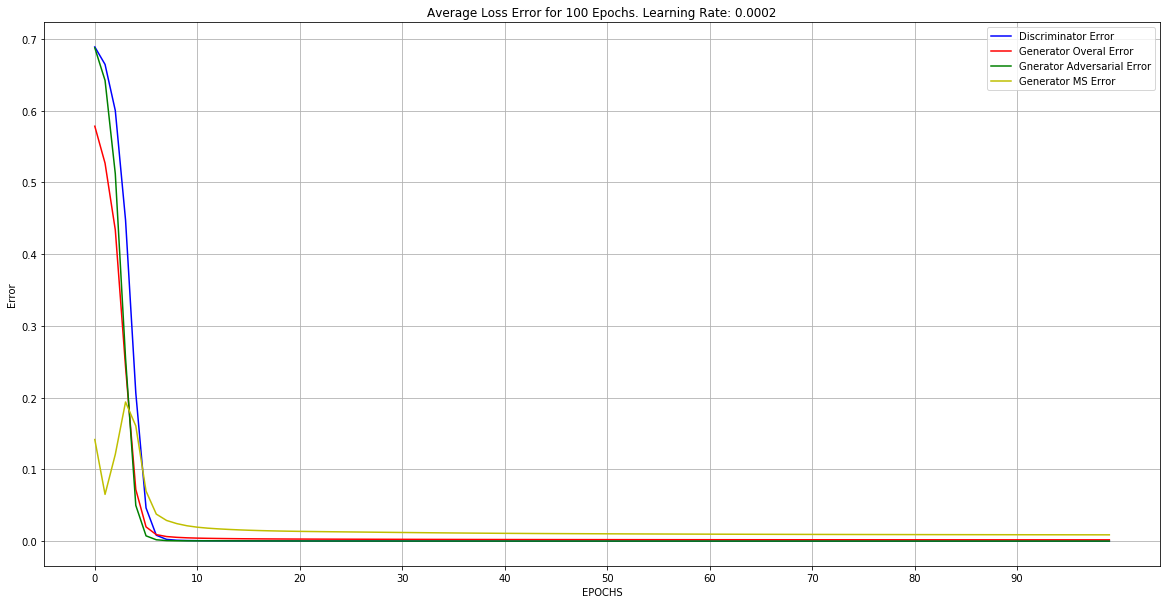

In [11]:
t=np.arange(epochs)
plt.figure(figsize=(20,10))
plt.title('Average Loss Error for {} Epochs. Learning Rate: {}'.format(epochs,lr))
plt.plot(t,Daverageloss,color='b',label='Discriminator Error')
plt.plot(t,Gaverageloss,color='r',label='Generator Overal Error')
plt.plot(t,ADVloss,color='g',label='Gnerator Adversarial Error')
plt.plot(t,MSEloss,color='y',label='Generator MS Error')
plt.xticks(np.arange(0,epochs,10))
#plt.yticks(np.arange(0,0.7,0.02))
plt.xlabel('EPOCHS')
plt.ylabel('Error')
plt.grid(True)
plt.legend()

## Predicted Images (32 x 32) From Low Scale Images(8 X 8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


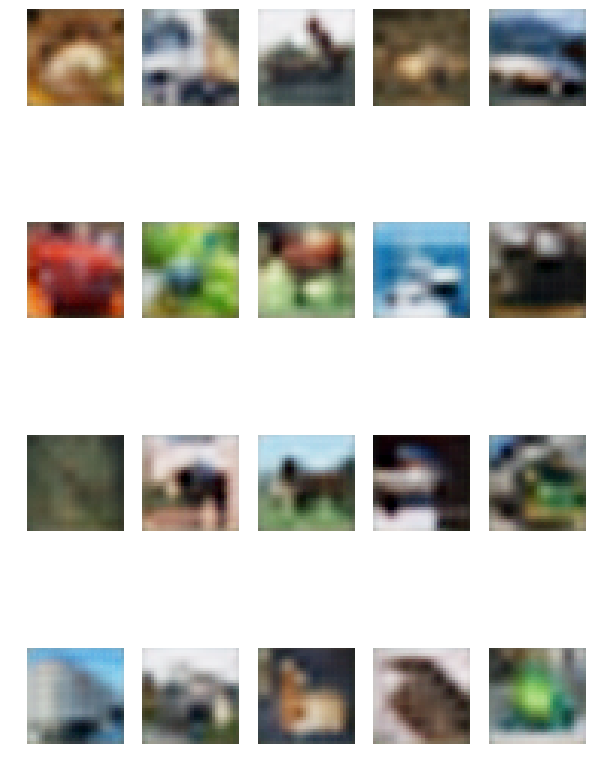

In [17]:
H=np.reshape(samples,(h,32,32,3))
fig=plt.figure(figsize=(10, 15))
columns = 5
rows = 4
for i in range(0, columns*rows ):
    #img = np.random.randint(10, size=(h,w))
    img=H[i]
    fig.add_subplot(rows, columns, (i+1))
    plt.axis('off')
    plt.imshow(img)
plt.show()

In [46]:
np.shape(samples)

(10, 20, 32, 32, 3)

## **Original Low Scale Images(8x8) From CIFAR10 dataset**

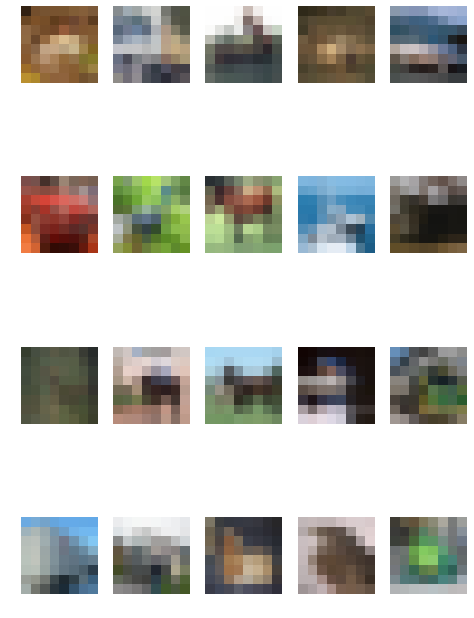

In [47]:
columns = 5
rows = 4
fig=plt.figure(figsize=(8,12))
for i in range(0, columns*rows ):
    #img = np.random.randint(10, size=(h,w))
    img=resized8[i]
    fig.add_subplot(rows, columns, (i+1))
    plt.axis('off')
    plt.imshow(img)
plt.show()

## **Original  Images( 32 x 32) From CIFAR10 dataset**

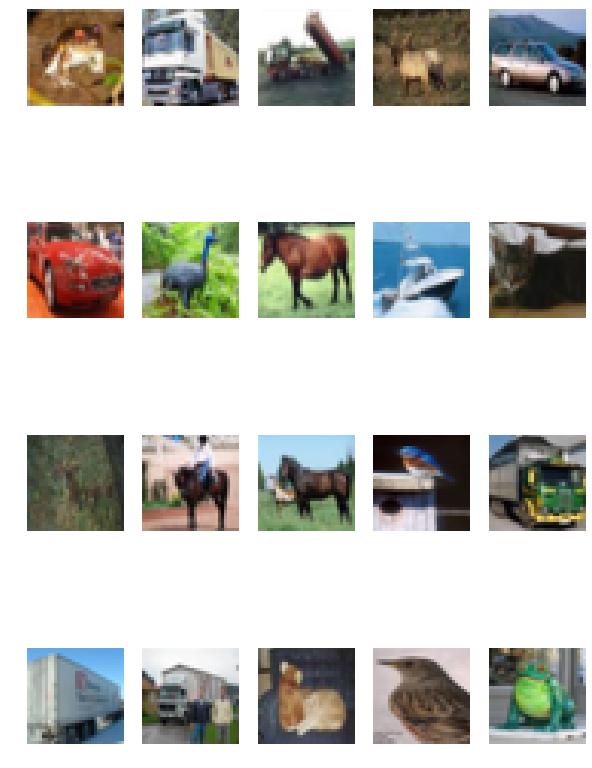

In [18]:
columns = 5
rows = 4
fig=plt.figure(figsize=(10,15))
for i in range(0, columns*rows ):
    #img = np.random.randint(10, size=(h,w))
    img=images[i]
    fig.add_subplot(rows, columns, (i+1))
    plt.axis('off')
    plt.imshow(img)
plt.show()

In [27]:
'''
H=np.reshape(samples,(batch_size*num_batches,32,32,3))     
y = images[:50]
y_ = H[:50]

con = tf.confusion_matrix(labels=y_, predictions=y )
sess = tf.Session()
with sess.as_default():
        print(sess.run(con))
'''

'\nH=np.reshape(samples,(batch_size*num_batches,32,32,3))     \ny = images[:50]\ny_ = H[:50]\n\ncon = tf.confusion_matrix(labels=y_, predictions=y )\nsess = tf.Session()\nwith sess.as_default():\n        print(sess.run(con))\n'

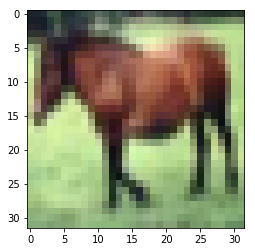

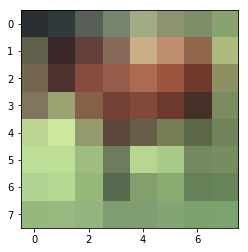

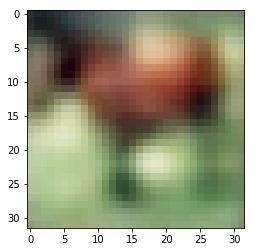

In [49]:
plt.figure(13)
plt.imshow(images[7], cmap='binary')
plt.figure(14)
plt.imshow(resized8[7], cmap='binary')
plt.figure(15)
plt.imshow(H[7], cmap='binary')